In [1]:
import pandas as pd
import numpy as np

import tubesml as tml
from tubesml.base import BaseTransformer, self_columns, reset_columns

from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone

import xgboost as xgb
import lightgbm as lgb

import warnings

In [14]:
df_train = pd.read_csv('data/train.csv')
train, test = tml.make_test(df_train, test_size=0.25, random_state=43, strat_feat=['Pclass', 'Sex'])
kfolds = KFold(n_splits=10, random_state=235, shuffle=True)
train_cols = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
24665,24665,0,3,"Jones, Rhett",male,44.0,0,0,25604,25.17,NaN,S
67933,67933,0,3,"Twomey, Paul",male,27.0,0,0,478284,11.53,NaN,S
41148,41148,0,3,"Brady, Amy",female,7.0,1,1,10375,80.13,NaN,S
49460,49460,0,3,"Shealy, William",male,37.0,0,0,C 15695,7.69,NaN,S
69515,69515,0,1,"Kolb, Willie",male,65.0,1,1,23480,77.39,C6991,C


In [15]:
from sklearn.ensemble import StackingClassifier

In [16]:
num_pipe_log = Pipeline([('fs_log', tml.DtypeSel(dtype='numeric')), 
                     ('imp_log', tml.DfImputer(strategy='median'))])

cat_pipe_log = Pipeline([('fs_log', tml.DtypeSel(dtype='category')), 
                     ('imp_log', tml.DfImputer(strategy='most_frequent')), 
                     ('dum_log', tml.Dummify(drop_first=True))])

proc_pipe_log = tml.FeatureUnionDf(transformer_list=[('num_log', num_pipe_log), 
                                                 ('cat_log', cat_pipe_log)])

num_pipe_tree = Pipeline([('fs_tree', tml.DtypeSel(dtype='numeric')), 
                     ('imp_tree', tml.DfImputer(strategy='median'))])

cat_pipe_tree = Pipeline([('fs_tree', tml.DtypeSel(dtype='category')), 
                     ('imp_tree', tml.DfImputer(strategy='most_frequent')), 
                     ('dum_tree', tml.Dummify(drop_first=True))])

proc_pipe_tree = tml.FeatureUnionDf(transformer_list=[('num_tree', num_pipe_tree), 
                                                 ('cat_tree', cat_pipe_tree)])

In [17]:
train_df = proc_pipe_log.fit_transform(train[train_cols])

In [16]:
estimators = [ ('tree', ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, max_depth=8)),
              ('logit', LogisticRegression(C=1, max_iter=2000)) ]

In [17]:
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [18]:
clf.fit(train_df, train.Survived)

StackingClassifier(estimators=[('tree',
                                ExtraTreesClassifier(max_depth=8,
                                                     n_estimators=1000,
                                                     n_jobs=-1)),
                               ('logit',
                                LogisticRegression(C=1, max_iter=2000))],
                   final_estimator=LogisticRegression())

In [19]:
clf.predict(train_df)

array([0, 0, 0, ..., 1, 0, 0])

In [28]:
full_pipe = Pipeline( [('processing', proc_pipe_log), 
                       ('model', StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=-1, passthrough=True)) ] )

full_pipe.fit(train[train_cols], train.Survived)

Pipeline(steps=[('processing',
                 FeatureUnionDf(transformer_list=[('num_log',
                                                   Pipeline(steps=[('fs_log',
                                                                    DtypeSel()),
                                                                   ('imp_log',
                                                                    DfImputer(strategy='median'))])),
                                                  ('cat_log',
                                                   Pipeline(steps=[('fs_log',
                                                                    DtypeSel(dtype='category')),
                                                                   ('imp_log',
                                                                    DfImputer(strategy='most_frequent')),
                                                                   ('dum_log',
                                                                  

In [29]:
oof = full_pipe.predict_proba(test[train_cols])[:,1]

oof

array([0.42453067, 0.19258619, 0.54089948, ..., 0.19366175, 0.28520509,
       0.4122465 ])

/home/lucabasa/Git/kaggle_competitions/tabular_playground/tabplay/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


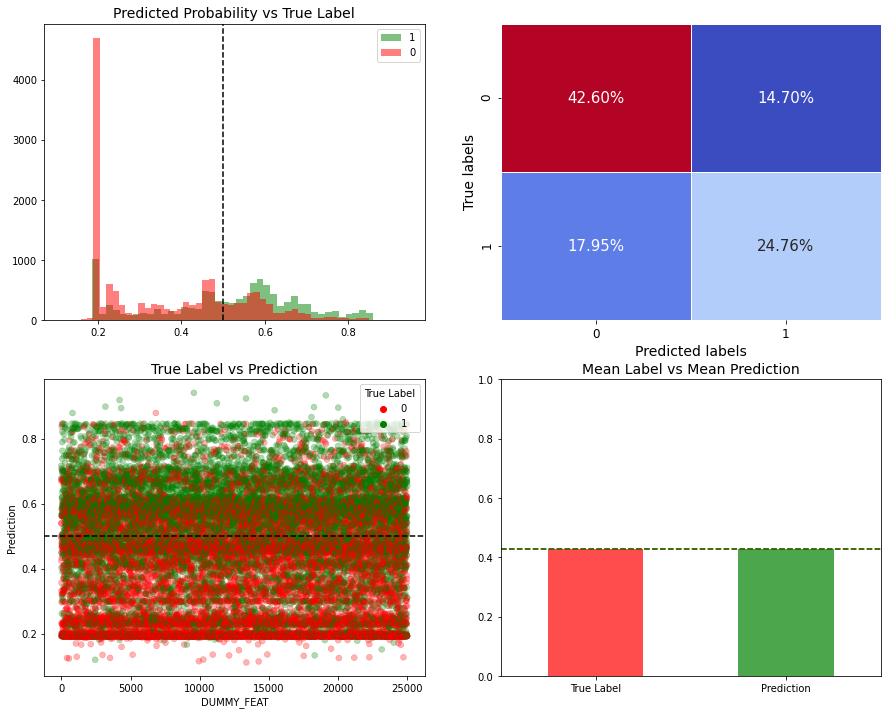

In [30]:
tml.plot_classification_probs(test, test.Survived, oof)

In [34]:
full_pipe = Pipeline( [('processing', proc_pipe_log), 
                       ('model', StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=-1)) ] )

oof = tml.cv_score(train[train_cols], train.Survived, full_pipe, cv=kfolds, predict_proba=True)

/home/lucabasa/Git/kaggle_competitions/tabular_playground/tabplay/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


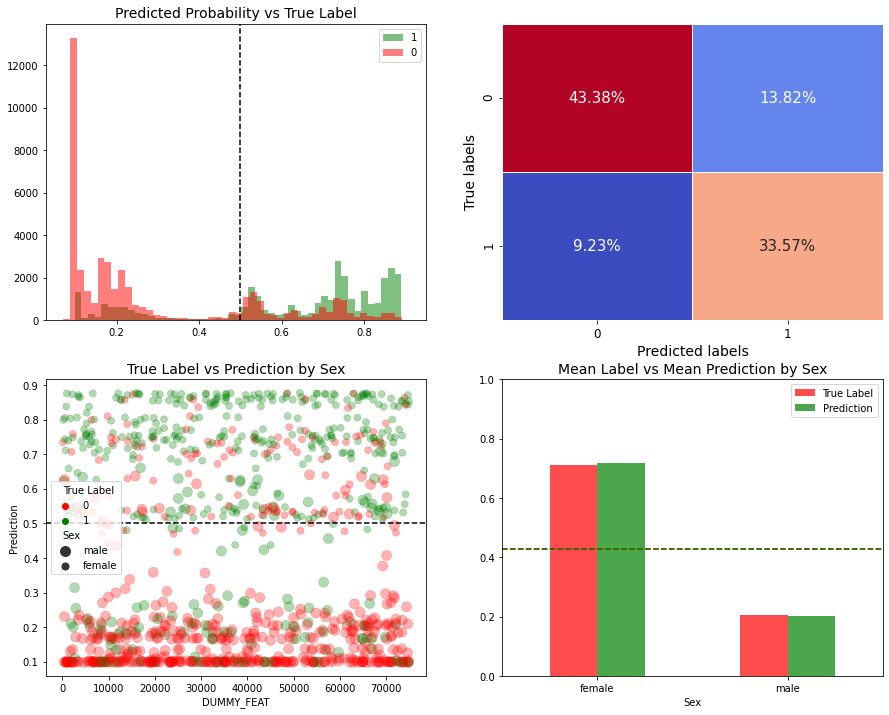

In [36]:
tml.plot_classification_probs(train, train.Survived, oof, sample=1000, hue_feat='Sex')

In [4]:
class Stacker(BaseTransformer):
    def __init__(self, estimators, final_estimator, cv, lay1_kwargs=None, passthrough=False):
        self.estimators = estimators
        self.final_estimator = final_estimator
        self.cv = cv
        self._lay1_kwargs_input(lay1_kwargs)
        self.feature_importances_ = None
        self.passthrough = passthrough
        
        
    def _lay1_kwargs_input(self, lay1_kwargs):
        if lay1_kwargs is None:
            self.lay1_kwargs = {}
        else:
            self.lay1_kwargs = lay1_kwargs
            
        for est in estimators:
            if est[0] not in self.lay1_kwargs.keys():
                self.lay1_kwargs[est[0]] = {}
            try:
                _ = self.lay1_kwargs[est[0]]['predict_proba']
            except KeyError:
                self.lay1_kwargs[est[0]]['predict_proba'] = False
                
                
    def return_feature_importances(self):
        try:
            return tml.get_coef(self.final_estimator, self.est_names)
        except (AttributeError, KeyError):
            return tml.get_feature_importance(self.final_estimator, self.est_names)
        
        
    def fit(self, X, y):
        self._estimators = [clone(model[1]) for model in self.estimators]
        self.est_names = [f'preds_{model[0]}' for model in self.estimators]
        
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.estimators)))
        for i, est in enumerate(self._estimators):
            oof = tml.cv_score(data=X, target=y, estimator=est, cv=self.cv, 
                               **self.lay1_kwargs[self.estimators[i][0]])
            out_of_fold_predictions[:, i] = oof
            self._estimators[i].fit(X, y)
        
        final_train = pd.DataFrame(out_of_fold_predictions, columns=self.est_names)
        self.final_estimator.fit(final_train, y)
        
        self.feature_importances_ = self.return_feature_importances()
        
        return self
    
    
    def _make_predict_test(self, X):
        
        first_layer_predictions = np.zeros((X.shape[0], len(self.estimators)))
        for i, est in enumerate(self._estimators):
            if self.lay1_kwargs[self.estimators[i][0]]['predict_proba']:
                first_layer_predictions[:, i] = self._estimators[i].predict_proba(X)[:,1]
            else:
                first_layer_predictions[:, i] = self._estimators[i].predict(X)
            
        final_predict = pd.DataFrame(first_layer_predictions, columns=self.est_names)
        
        return final_predict
    
    
    def predict(self, X, y=None):
        
        final_predict = self._make_predict_test(X)
        
        preds = self.final_estimator.predict(final_predict)
        
        return preds
    
    
    def predict_proba(self, X, y=None):
        
        final_predict = self._make_predict_test(X)
        
        preds = self.final_estimator.predict_proba(final_predict)
        
        return preds[:, 1]

In [5]:
estimators = [ ('tree', ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, max_depth=8)),
              ('logit', LogisticRegression(C=1, max_iter=2000)) ]

final_estimator=LogisticRegression()

kfolds = KFold(n_splits=5, random_state=235, shuffle=True)

In [12]:
stk = Stacker(estimators, final_estimator, cv=kfolds, lay1_kwargs={'logit': {'predict_proba': True}})

In [13]:
stk.fit(train_df, train.Survived)

Stacker(cv=KFold(n_splits=5, random_state=235, shuffle=True),
        estimators=[('tree',
                     ExtraTreesClassifier(max_depth=8, n_estimators=1000,
                                          n_jobs=-1)),
                    ('logit', LogisticRegression(C=1, max_iter=2000))],
        final_estimator=LogisticRegression(),
        lay1_kwargs={'logit': {'predict_proba': True},
                     'tree': {'predict_proba': False}})

In [15]:
stk.feature_importances_

,feat,score
1,preds_logit,4.555303
0,preds_tree,0.210400


In [16]:
stk.predict(train_df)

array([0, 0, 0, ..., 1, 0, 0])

In [8]:
num_pipe_log = Pipeline([('fs_log', tml.DtypeSel(dtype='numeric')), 
                     ('imp_log', tml.DfImputer(strategy='median'))])

cat_pipe_log = Pipeline([('fs_log', tml.DtypeSel(dtype='category')), 
                     ('imp_log', tml.DfImputer(strategy='most_frequent')), 
                     ('dum_log', tml.Dummify(drop_first=True))])

proc_pipe_log = tml.FeatureUnionDf(transformer_list=[('num_log', num_pipe_log), 
                                                 ('cat_log', cat_pipe_log)])

num_pipe_tree = Pipeline([('fs_tree', tml.DtypeSel(dtype='numeric')), 
                     ('imp_tree', tml.DfImputer(strategy='median'))])

cat_pipe_tree = Pipeline([('fs_tree', tml.DtypeSel(dtype='category')), 
                     ('imp_tree', tml.DfImputer(strategy='most_frequent')), 
                     ('dum_tree', tml.Dummify(drop_first=True))])

proc_pipe_tree = tml.FeatureUnionDf(transformer_list=[('num_tree', num_pipe_tree), 
                                                 ('cat_tree', cat_pipe_tree)])


estimators = [ ('tree', ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, max_depth=8)),
              ('logit', Pipeline([('proc_logit', tml.DfScaler()), ('model_logit', LogisticRegression(C=1, max_iter=2000))])) ]

final_estimator=LogisticRegression()

kfolds = KFold(n_splits=5, random_state=235, shuffle=True)

In [9]:
stk = Stacker(estimators, final_estimator, cv=kfolds, lay1_kwargs={'logit': {'predict_proba': True}})

In [10]:
stk.fit(train, train.Survived)

Stacker(cv=KFold(n_splits=5, random_state=235, shuffle=True),
        estimators=[('tree',
                     ExtraTreesClassifier(max_depth=8, n_estimators=1000,
                                          n_jobs=-1)),
                    ('logit',
                     Pipeline(steps=[('proc_logit', DfScaler()),
                                     ('model_logit',
                                      LogisticRegression(C=1,
                                                         max_iter=2000))]))],
        final_estimator=LogisticRegression(),
        lay1_kwargs={'logit': {'predict_proba': True},
                     'tree': {'predict_proba': False}})

In [18]:


estm = [('tree', ExtraTreesClassifier(max_depth=3)), 
            ('logit', LogisticRegression())]

stk = Stacker(estimators=estm, 
                        final_estimator=ExtraTreesClassifier(), 
                        cv=kfolds, lay1_kwargs={'logit': {'predict_proba': True}})

pipe = Pipeline([('scl', tml.DfScaler()), ('model', stk)])

param_grid = {'model__final_estimator__max_depth': [3,4,5]}

result, best_param, best_estimator = tml.grid_search(data=train_df, target=train.Survived, estimator=stk, 
                                                         param_grid=param_grid, scoring='accuracy', cv=3)

ValueError: Invalid parameter model for estimator Stacker(cv=KFold(n_splits=10, random_state=235, shuffle=True),
        estimators=[('tree', ExtraTreesClassifier(max_depth=3)),
                    ('logit', LogisticRegression())],
        final_estimator=ExtraTreesClassifier(),
        lay1_kwargs={'logit': {'predict_proba': True},
                     'tree': {'predict_proba': False}}). Check the list of available parameters with `estimator.get_params().keys()`.

In [10]:
pipe.get_params()

{'memory': None,
 'steps': [('scl', DfScaler()),
  ('model',
   Stacker(cv=KFold(n_splits=5, random_state=235, shuffle=True),
           estimators=[('tree', ExtraTreesClassifier(max_depth=3)),
                       ('logit', LogisticRegression())],
           final_estimator=ExtraTreesClassifier(),
           lay1_kwargs={'logit': {'predict_proba': True},
                        'tree': {'predict_proba': False}}))],
 'verbose': False,
 'scl': DfScaler(),
 'model': Stacker(cv=KFold(n_splits=5, random_state=235, shuffle=True),
         estimators=[('tree', ExtraTreesClassifier(max_depth=3)),
                     ('logit', LogisticRegression())],
         final_estimator=ExtraTreesClassifier(),
         lay1_kwargs={'logit': {'predict_proba': True},
                      'tree': {'predict_proba': False}}),
 'scl__feature_range': (0, 1),
 'scl__method': 'standard',
 'model__cv': KFold(n_splits=5, random_state=235, shuffle=True),
 'model__estimators': [('tree', ExtraTreesClassifier(max_de

In [14]:
grid_params = {'final_estimator__C': [1, 10]}

tml.grid_search(train_df, train.Survived, stk, grid_params, 'accuracy', kfolds)

(  param_final_estimator__C  mean_train_score  std_train_score  \
 0                        1          0.768657         0.000936   
 1                       10          0.768493         0.000853   
 
    mean_test_score  std_test_score  mean_fit_time  std_fit_time  \
 0         0.768067        0.002721      66.582085      0.040727   
 1         0.768000        0.002819      50.065222      8.245520   
 
    mean_score_time  std_score_time  
 0         1.046460        0.018424  
 1         0.888267        0.086067  ,
 {'final_estimator__C': 1},
 Stacker(cv=KFold(n_splits=5, random_state=235, shuffle=True),
         estimators=[('tree',
                      ExtraTreesClassifier(max_depth=8, n_estimators=1000,
                                           n_jobs=-1)),
                     ('logit',
                      Pipeline(steps=[('proc_logit', DfScaler()),
                                      ('model_logit',
                                       LogisticRegression(C=1,
             

In [15]:
stk.get_params()

{'cv': KFold(n_splits=5, random_state=235, shuffle=True),
 'estimators': [('tree',
   ExtraTreesClassifier(max_depth=8, n_estimators=1000, n_jobs=-1)),
  ('logit',
   Pipeline(steps=[('proc_logit', DfScaler()),
                   ('model_logit', LogisticRegression(C=1, max_iter=2000))]))],
 'final_estimator__C': 1.0,
 'final_estimator__class_weight': None,
 'final_estimator__dual': False,
 'final_estimator__fit_intercept': True,
 'final_estimator__intercept_scaling': 1,
 'final_estimator__l1_ratio': None,
 'final_estimator__max_iter': 100,
 'final_estimator__multi_class': 'auto',
 'final_estimator__n_jobs': None,
 'final_estimator__penalty': 'l2',
 'final_estimator__random_state': None,
 'final_estimator__solver': 'lbfgs',
 'final_estimator__tol': 0.0001,
 'final_estimator__verbose': 0,
 'final_estimator__warm_start': False,
 'final_estimator': LogisticRegression(),
 'lay1_kwargs': {'logit': {'predict_proba': True},
  'tree': {'predict_proba': False}},
 'passthrough': False}

In [24]:
tmp = xgb.XGBClassifier()

tmp.set_params(**{'n_estimators': 10})

tmp

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [25]:
tmp = lgb.LGBMClassifier()

tmp.set_params(**{'n_estimators': 10})

tmp

LGBMClassifier(n_estimators=10)

In [28]:
np.mean([2, 4, 45, 6]).astype(int)

14